<h1>1.사전준비

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 79.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=176f04e48664bf6356f1005d2beb15f1511feb99ce89d005f2c762c1ecf8fe47
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>2.두 parquet 합치기

In [ ]:
# 코로나 이전 파일 확인
df3 = spark.read.parquet('/content/drive/MyDrive/data/previous_corona')
df3

DataFrame[사용일자: date, 노선명: string, 역명: string, 승차총승객수: int, 하차총승객수: int, 이용자수: int]

In [ ]:
# 코로나 이후 파일 확인
df4 = spark.read.parquet('/content/drive/MyDrive/data/post_corona')
df4

DataFrame[사용일자: string, 노선명: string, 역명: string, 승차총승객수: int, 하차총승객수: int, 이용자수: int]

두 dataframe을 보면 '사용일자' 컬럼의 dataType가 다른것을 알 수 있다. 만약 이대로 두 dataframe을 합친다면, 에러가 발생하게 된다. 우리가 원하는 dataType은 date이므로 post_corona의 '사용일자' 컬럼의 dataType을 변경하겠다.

In [ ]:
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [ ]:
# 데이터 타입 변경
df4 = df4.withColumn('사용일자',F.to_date(F.col("사용일자"),"yyyy-MM-dd"))
df4

DataFrame[사용일자: date, 노선명: string, 역명: string, 승차총승객수: int, 하차총승객수: int, 이용자수: int]

In [ ]:
# 두 데이터프레임을 합침(df3에 df4를 이어붙임)
df = df3.union(df4)
df

DataFrame[사용일자: date, 노선명: string, 역명: string, 승차총승객수: int, 하차총승객수: int, 이용자수: int]

혹시 손실된 데이터가 있는지 확인. 이유는 모르겠는데 하나의 셀에서 count하면 에러가 발생했다.

In [ ]:
df3.count()

428518

In [ ]:
df4.count()

380925

In [ ]:
df.count()

809443

In [ ]:
428518 + 380925

809443

잘못된 노선 데이터가 있는지 확인(이후 다른 슬라이드 작업에서 일부 노선들이 통합됨)

In [ ]:
df.select('노선명').distinct().show(30)

+----------+
|    노선명|
+----------+
|    일산선|
|    장항선|
|    경부선|
|우이신설선|
|    분당선|
|     7호선|
|    수인선|
|    안산선|
|     4호선|
|     1호선|
|    경의선|
|     3호선|
|    경강선|
|    경춘선|
|     9호선|
|     6호선|
|     5호선|
|     8호선|
|  공항철도|
|    과천선|
|    경인선|
|    중앙선|
|     2호선|
|    경원선|
+----------+



널값확인

In [ ]:
df.where(F.col('이용자수').isNull()==True).count()

0

이상값확인

In [ ]:
df.where(F.col('이용자수')<0).count()

0

In [ ]:
pdf = df.select("*").toPandas()
pdf

,사용일자,노선명,역명,승차총승객수,하차총승객수,이용자수
0,2018-01-01,1호선,서울역,40213,34505,74718
1,2018-01-01,우이신설선,신설동,699,809,1508
2,2018-01-01,우이신설선,보문,754,803,1557
3,2018-01-01,우이신설선,성신여대입구(돈암),2228,2276,4504
4,2018-01-01,우이신설선,정릉,1844,1685,3529
...,...,...,...,...,...,...
809438,2021-09-30,9호선,신논현,28562,28302,56864
809439,2021-09-30,9호선,언주,9859,10044,19903
809440,2021-09-30,9호선,선정릉,9308,10135,19443
809441,2021-09-30,9호선,삼성중앙,6389,6552,12941


In [ ]:
# 저장(이후 필요할지도?)
pdf.to_parquet('test.parquet')

In [ ]:
# 저장한 파일 확인
pq = spark.read.parquet('test.parquet')
pq.show()

+----------+----------+------------------+------------+------------+--------+
|  사용일자|    노선명|              역명|승차총승객수|하차총승객수|이용자수|
+----------+----------+------------------+------------+------------+--------+
|2018-01-01|     1호선|            서울역|       40213|       34505|   74718|
|2018-01-01|우이신설선|            신설동|         699|         809|    1508|
|2018-01-01|우이신설선|              보문|         754|         803|    1557|
|2018-01-01|우이신설선|성신여대입구(돈암)|        2228|        2276|    4504|
|2018-01-01|우이신설선|              정릉|        1844|        1685|    3529|
|2018-01-01|우이신설선|      북한산보국문|        2706|        2637|    5343|
|2018-01-01|우이신설선|              솔샘|        2242|        2128|    4370|
|2018-01-01|우이신설선|        삼양사거리|        1141|        1170|    2311|
|2018-01-01|우이신설선|              삼양|        1079|        1206|    2285|
|2018-01-01|우이신설선|              화계|        1492|        1418|    2910|
|2018-01-01|우이신설선|            가오리|        1783|        1796|    3579|
|2018-01-01|우이신설선|     

<h1>일별 이용자수 뽑을겸 그냥 만들어보는 그래프

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
# '사용일자' 그룹으로 나누어 '승차총승객'를 모두 더해준 '일별이용자수' 칼럼을 생성한다. 그리고 '사용일자'기준으로 내림차순 정리한다.
user_per_date = df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.desc('`사용일자`'))
# 그래프를 그리기 위해 판다스 dataframe으로 변환
pd_user_per_date = user_per_date.select("*").toPandas()
pd_user_per_date

,사용일자,일별이용자수
0,2021-09-30,6398703
1,2021-09-29,6069925
2,2021-09-28,6290961
3,2021-09-27,6283331
4,2021-09-26,3092457
...,...,...
1364,2018-01-05,8134256
1365,2018-01-04,7705415
1366,2018-01-03,7681469
1367,2018-01-02,7505016


parquet파일로 저장 & 확인

In [ ]:
user_per_date.write.parquet('/content/drive/MyDrive/data/main.parquet')

In [ ]:
pq = spark.read.parquet('/content/drive/MyDrive/data/main.parquet')
pq.count()

1369

그래프 그려보기

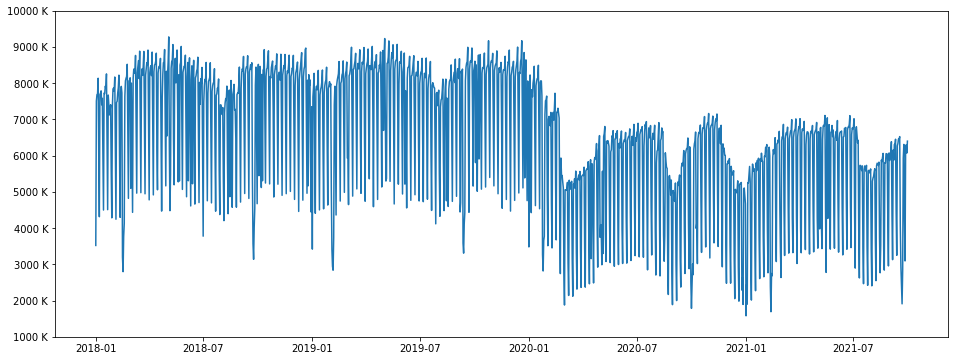

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(pd_user_per_date.사용일자, pd_user_per_date.일별이용자수/1000, label='expoential')

plt.ylim([1000, 10000])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
leg = plt.legend()
ax.get_legend().remove()

plt.show() 